In [124]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

In [170]:
#Output voltages
vo = {
    4: 3.986,
    7: 6.99,
    10: 9.98
}
Vg = 18
# Functions Used For Lab
def unpack_oscope(filepath):
    data = pd.read_csv(filepath)
    increment = float(data["Increment"][0])
    data = data.iloc[1: , :]
    data = data.astype(float)
    data["time"] = data["X"] * increment
    return data

def plot_vsh_vdr(voltages):
    start_tick = 0
    end_tick = -1
    
    for voltage in voltages: 
        data = unpack_oscope(f"../data/{voltage}V.csv")
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.', s=0.5)
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

        ax1.sharex(ax2)
        ax1.title.set_text("Shunt Voltage")
        ax2.title.set_text("Drain Voltage")
        ax2.set_xlabel("Time (s)")
        fig.suptitle(f"Shunt and Drain Voltage for V_out = {voltage}V") 

        plt.show()
        
def plot_freq(name, subtitle):
    start_tick = 0
    end_tick = -1
    
    data = unpack_oscope(f"../data/{name}.csv")
    fig, ax = plt.subplots()  
    # Drain Voltage
    ax.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.', s=0.5)

    ax.title.set_text("Drain Voltage")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Drain Voltage (V)")
    ax.set_title(f"Drain Ringing: {subtitle}") 

    plt.show()
    

def get_dvdr_dt(voltage, plot):
    start_tick = 4500-((voltage-4)*100)
    end_tick = 5500
    
    data = unpack_oscope(f"../data/{voltage}V.csv")
    # compute slope m and intercept b
    m, b = np.polyfit(data["time"][start_tick:end_tick],
                      data["CH1"][start_tick:end_tick], deg=1)

    if plot:
        # Plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.')
        # Line of best fit
        # plot fitted I_PK = m*voltages + b
        ax1.axline(xy1=(0.95e-5, 0.95e-5*m +b), slope=m, color='r', label=f'dvdr_dt = {m:.2f}(vcomp) {b:+.2f}')
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick], data["CH2"][start_tick:end_tick], marker='.')

        
        # Extras
        ax1.title.set_text(f"Gate Voltage @ V=V")
        ax2.title.set_text(f"Gate to Drain Voltage @ V=V")
        fig.suptitle(f"V =V") 
        plt.show()
    return m

def get_inductance(voltages):
    R = 0.05 # Ohms
    L = []
    Vg = 18 # V
    
    for voltage in voltages:
        didt = get_dvdr_dt(voltage, False) / R
        L.append(Vg / didt)
        
    return L, np.mean(L)

def get_D(voltage, plot, start_tick, end_tick, start_tick_D, end_tick_D):
    
    data = unpack_oscope(f"../data/{voltage}V.csv")
    Ts = data["time"][len(data["time"]) + end_tick] - data["time"][start_tick]
    
    Ta = data["time"][len(data["time"]) + end_tick_D] - data["time"][start_tick_D]
    D = Ta/Ts

    if plot:
        # Plot
        fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
        # Shunt voltage
        # ax1.scatter(data["time"][start_tick:end_tick], data["CH1"][start_tick:end_tick], marker='.', s=0.5)
        # Line of best fit
        # plot fitted I_PK = m*voltages + b
        # ax1.axline(xy1=(0.95e-5, 0.95e-5*m +b), slope=m, color='r', label=f'dvdr_dt = {m:.2f}(vcomp) {b:+.2f}')
        # Drain Voltage
        ax2.scatter(data["time"][start_tick_D:end_tick_D], data["CH2"][start_tick_D:end_tick_D], marker='.', s=0.5)

        
        # Extras
        ax1.title.set_text(f"Gate Voltage @ V=V")
        ax2.title.set_text(f"Gate to Drain Voltage @ V=V")
        fig.suptitle(f"V =V") 
        plt.show()
    return D

def get_turns_ratio(voltages, D, L_measured):
    a = []
    L_crit = 24.7 * 10**-6 #H
    alpha = L_measured/L_crit
    for i, voltage in enumerate(voltages):
        ratio = vo[voltage]/Vg
        a.append(ratio * (np.sqrt(alpha)-D[i])/D[i])
    return a
        
        
        
        
    

In [179]:
D_4 = get_D(4, False, 900, -1100, 4500, -6100)
D_7 = get_D(7, False, 900, -1100, 3450, -6050)
D_10 = get_D(10, False, 900, -1100, 2610, -5800)
get_turns_ratio([4, 7, 10],
                [D_4, D_7, D_10],
                17.273e-6)

[1.1012884789682782, 0.9106395104716751, 0.7370691963290822]

Q1 & Q3:


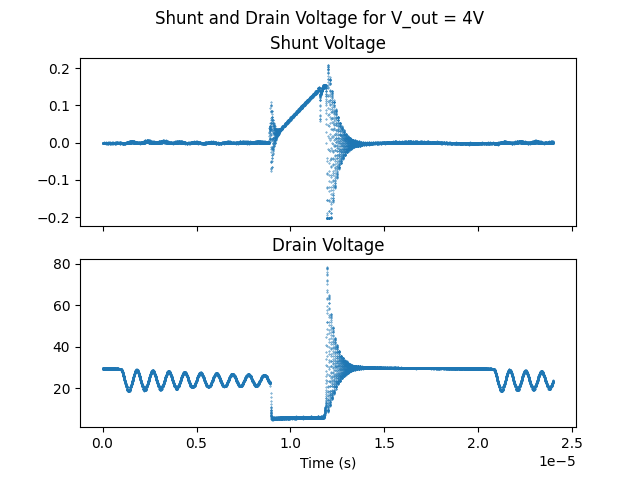

/tmp/ipykernel_344646/3416373797.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)


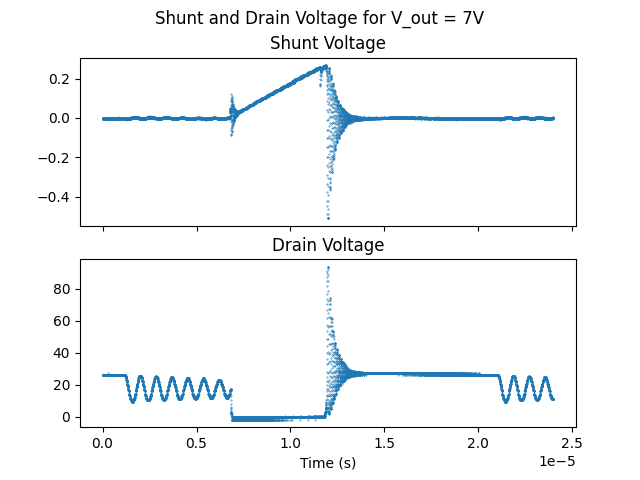

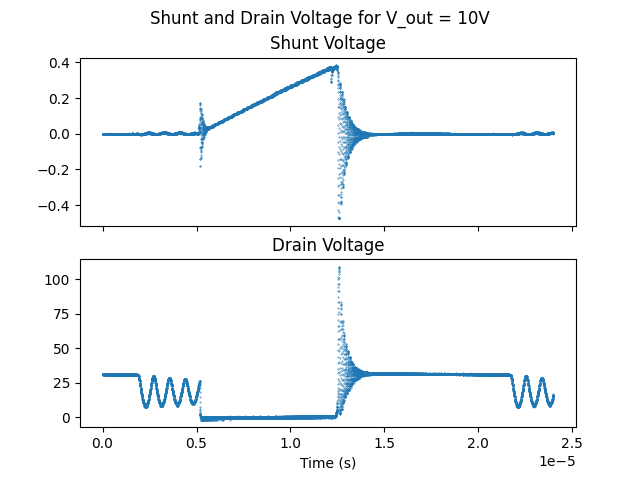

In [127]:
print("Q1 & Q3:")
plot_vsh_vdr([4, 7, 10])

Q2:
| **Nominal Output Voltage** | **Measured Output Voltage** | **Input Current** |
|----------------------------|-----------------------------|-------------------|
| 4 V                        | 3.986 V                     | 0.25 A            |
| 7 V                        | 6.99 V                      | 0.71 A            |
| 10 V                       | 9.98 V                      | 1.42 A            |

Q4:


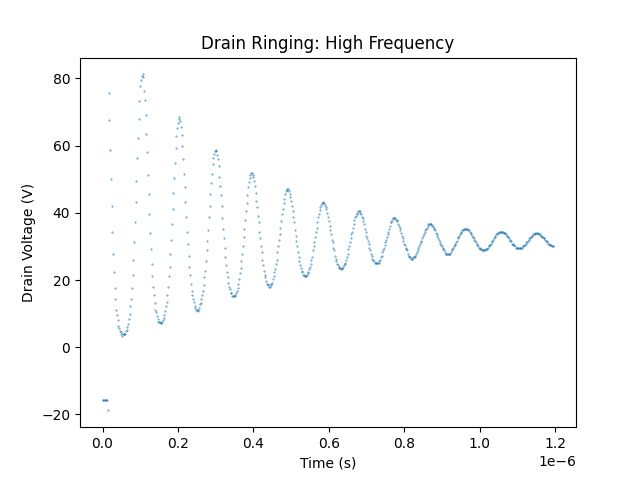

Q5:


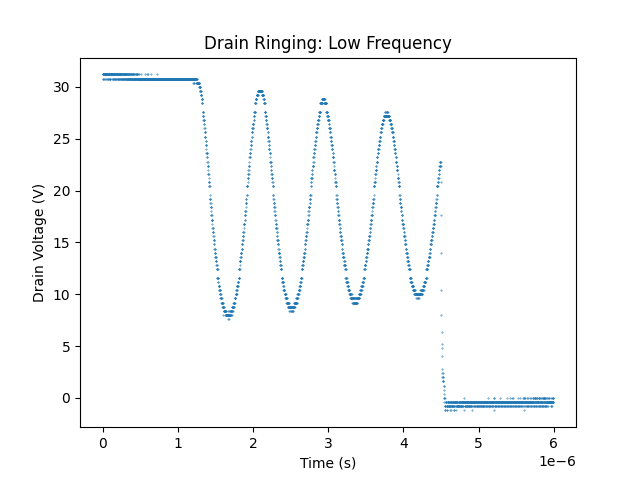

In [128]:
print("Q4:")
plot_freq("10V_high_freq", "High Frequency")

print("Q5:")
plot_freq("10V_low_freq", "Low Frequency")

In [129]:
inductances, avg_inductance = get_inductance([4, 7, 10])
print(f"Q6: The average inductance was {avg_inductance*10**6} uH, the raw values were {inductances} H based on shunt voltage slope")



Q6: The average inductance was 17.27300676542448 uH, the raw values were [1.7475275664011628e-05, 1.7128259633696706e-05, 1.72154849985651e-05] H based on shunt voltage slope


Q9: Plots given above for ringing waveforms for Q4/Q5.

In [130]:
high_frequency = 5/(5.82e-7 - 1.05e-7) * units.hertz
high_frequency_delta = (1/5)*np.log(81/42.3)
print("FET turn-off damped natural frequency:", high_frequency.to_compact())
print("FET turn-off damping ratio:", high_frequency_delta/np.sqrt(4*np.pi**2 + high_frequency_delta**2))

low_frequency = 2/(3.77e-6 - 2.08e-6) * units.hertz
low_frequency_delta = (1/2)*np.log(29.41/27.38)
print("Diode turn-off damped natural frequency:", low_frequency.to_compact())
print("Diode turn-off damping ratio:", low_frequency_delta/np.sqrt(4*np.pi**2 + low_frequency_delta**2))


FET turn-off damped natural frequency: 10.482180293501047 MHz
FET turn-off damping ratio: 0.020674965694384147
Diode turn-off damped natural frequency: 1.183431952662722 MHz
Diode turn-off damping ratio: 0.0056914423824812755


Based on the measurements, the electrical requirements are satisfied: L_crit 
